In [23]:
%matplotlib inline
import os
from plantcv import plantcv as pcv
import cv2
import numpy as np
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 10]

In [29]:
# The options class mimics the options function in a PlantCV workflow (mimics using argparse)
class options:
    def __init__(self):
        # Input image
        self.image = "2017-01-18_1510_ch129-pos01.jpg"
        # Debug = "plot" (Jupyter), "print" (file), or None
        self.debug = "plot"
        # Should we output analysis images from analyze_* functions
        self.writeimg = False
        # Name of results file
        self.result = "test_results.txt"

In [31]:
# Initialize instance of options called args to mimic the use of argparse in work flow script
args = options()
pcv.params.debug = args.debug

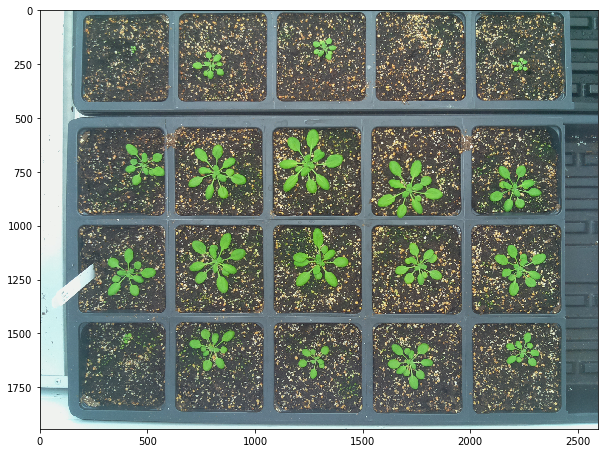

In [32]:
# Open image
img, imgpath, imgname = pcv.readimage(filename=args.image)

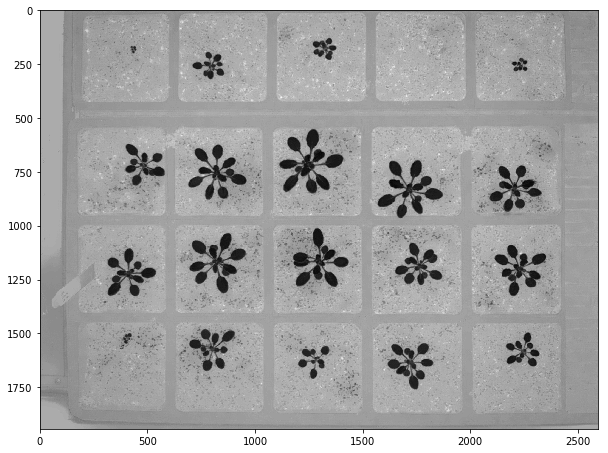

In [38]:
# Convert RGB to LAB and keep the A (green-magenta) channel
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

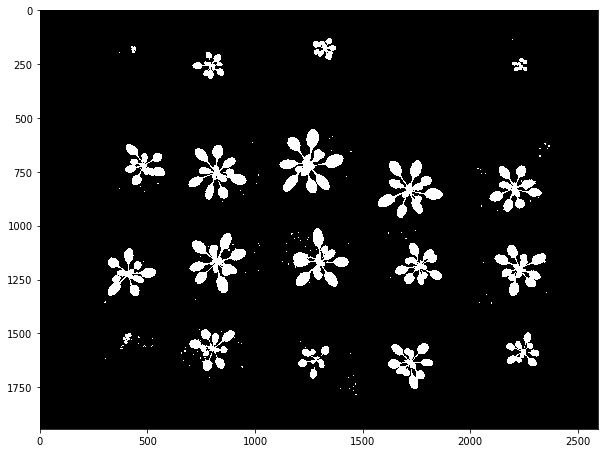

In [39]:
# Threshold the A channel using the Otsu auto-threshold method
bin_img = pcv.threshold.otsu(gray_img=a, max_value=255, object_type="dark")

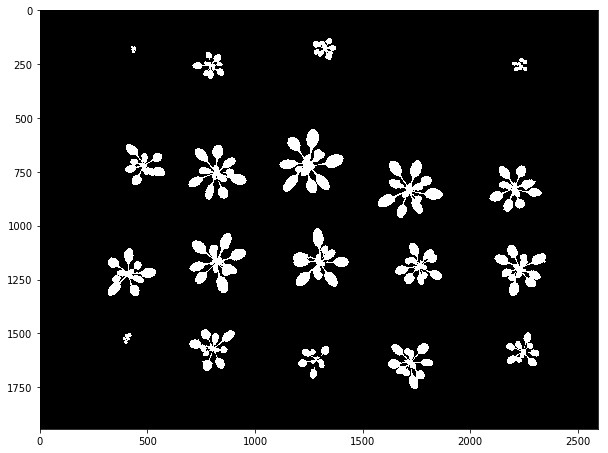

In [40]:
# Remove salt-and-pepper noise from background
cleaned_img = pcv.fill(bin_img=bin_img, size=100)

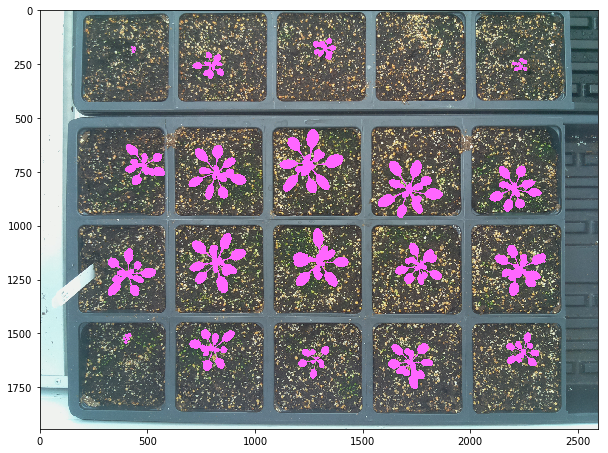

In [49]:
# Detect contours in binary image
all_contours, all_hierarchy = pcv.find_objects(img=img, mask=cleaned_img)

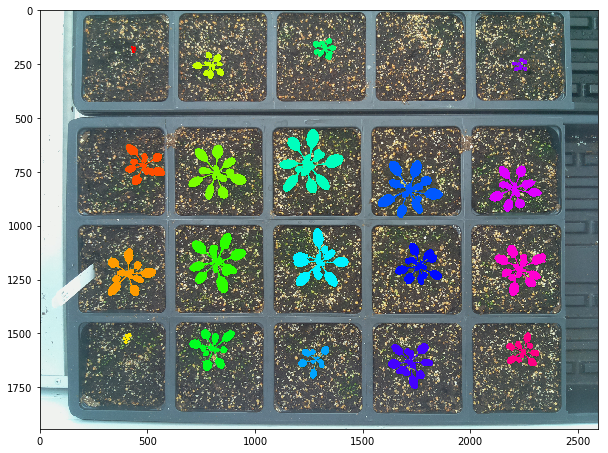

In [50]:
# Cluster contours to detect individual plants
clusters, contours, contour_hierarchy = pcv.cluster_contours(img=img, roi_objects=all_contours,
                                                             roi_obj_hierarchy=all_hierarchy, nrow=4, ncol=5)

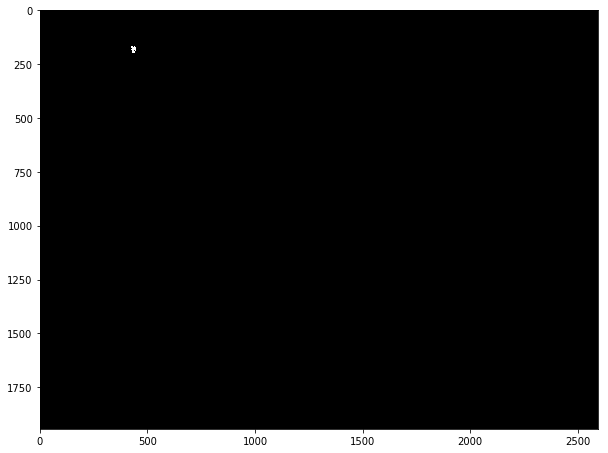

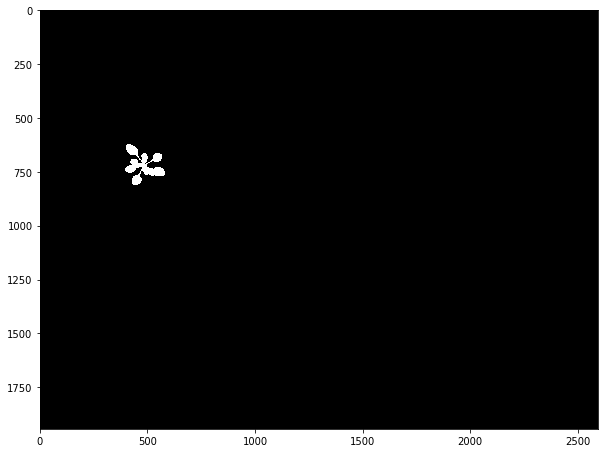

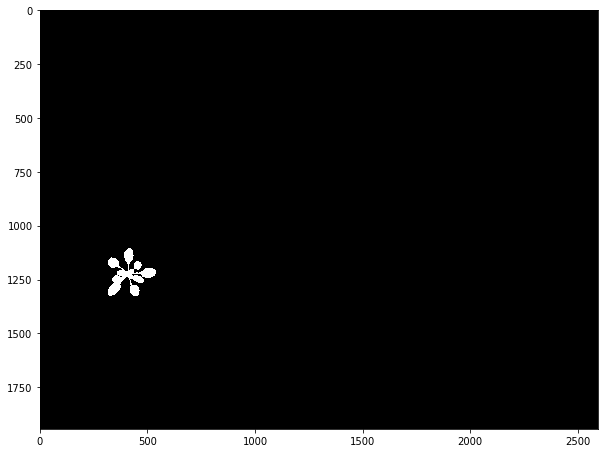

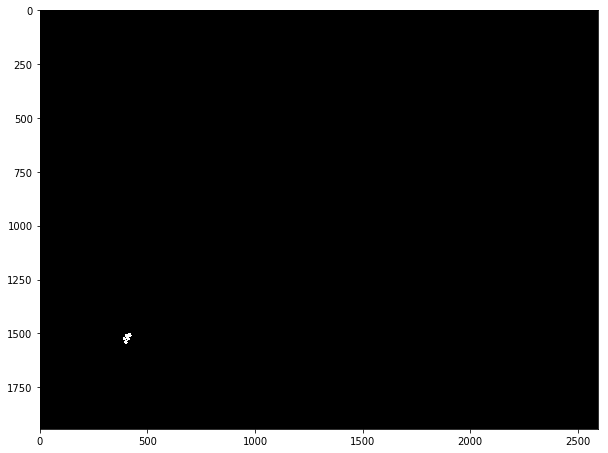

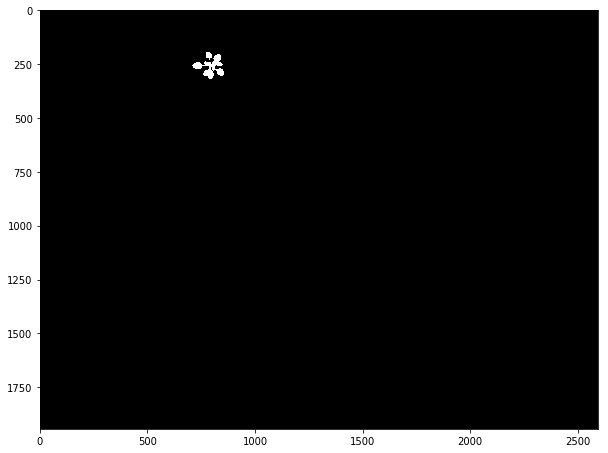

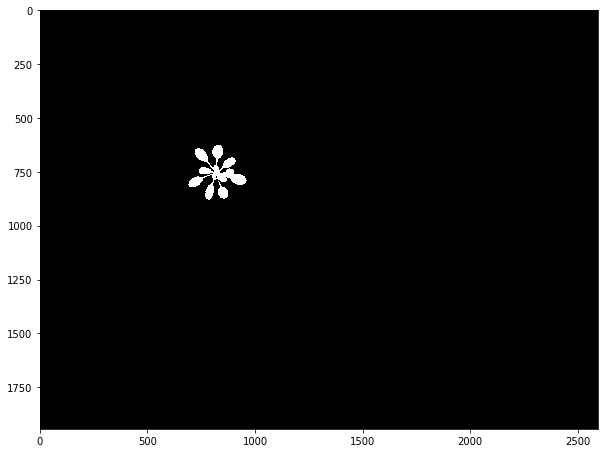

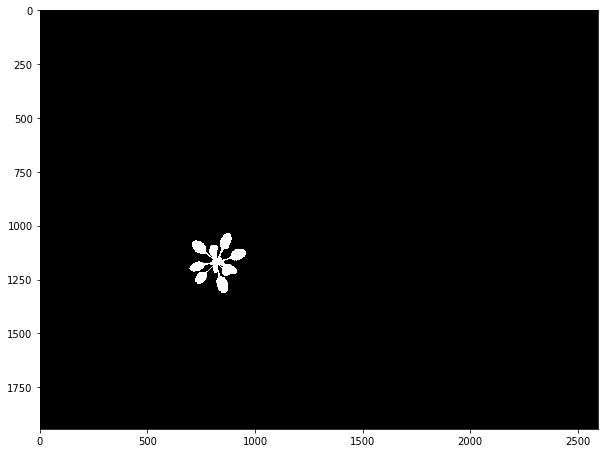

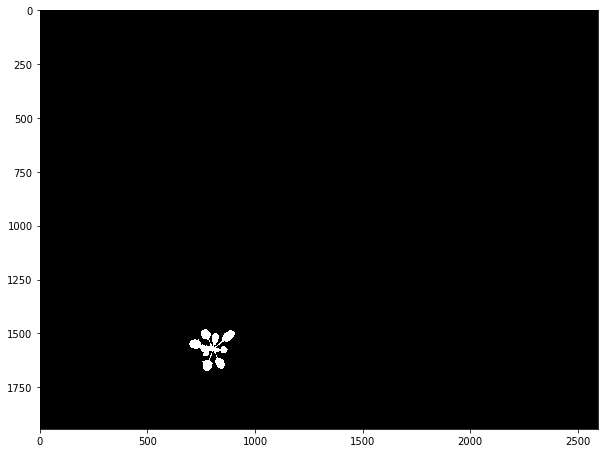

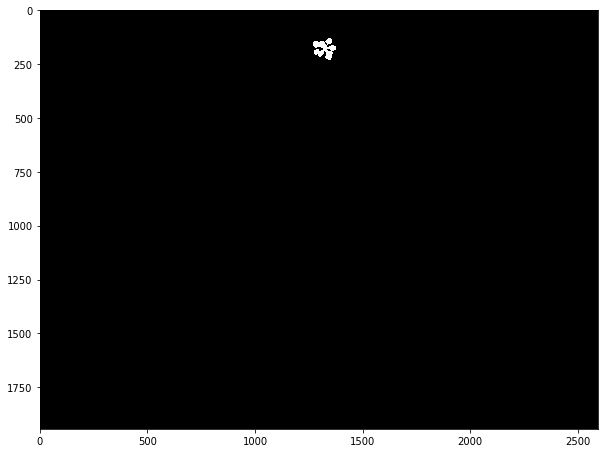

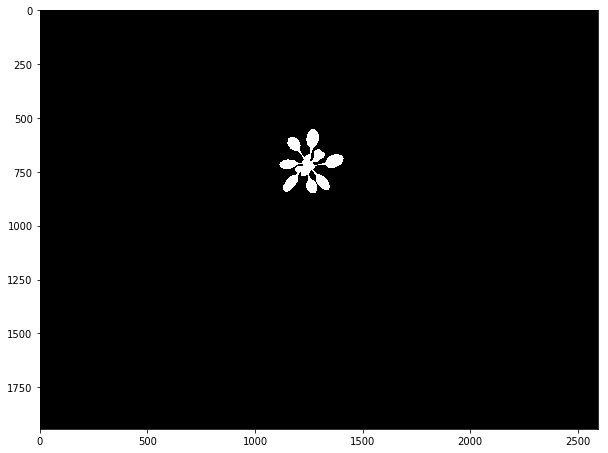

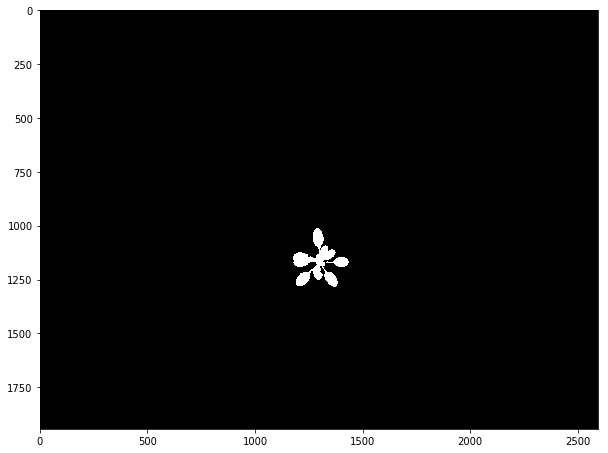

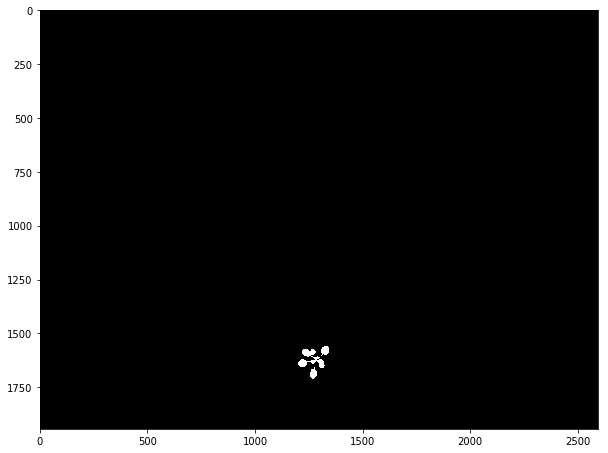

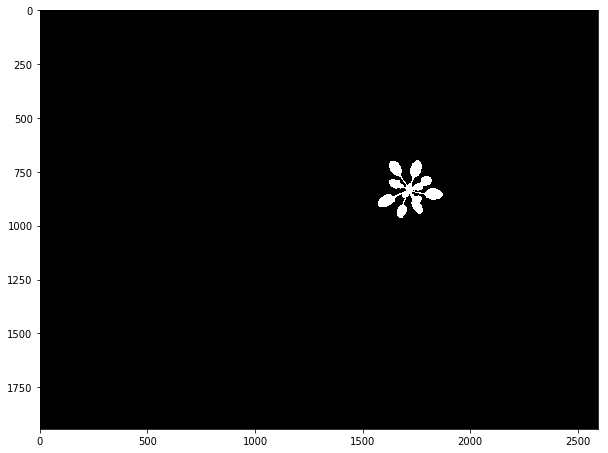

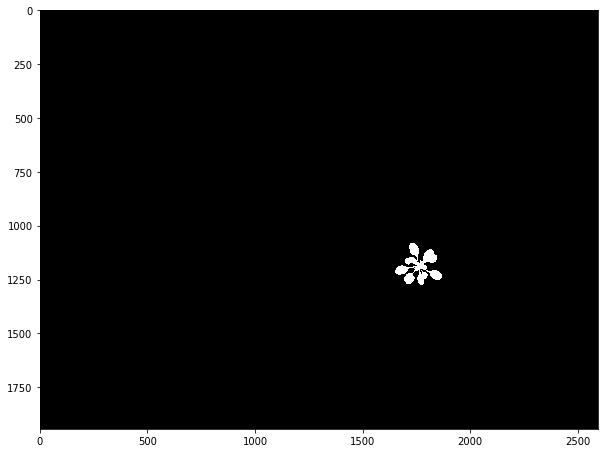

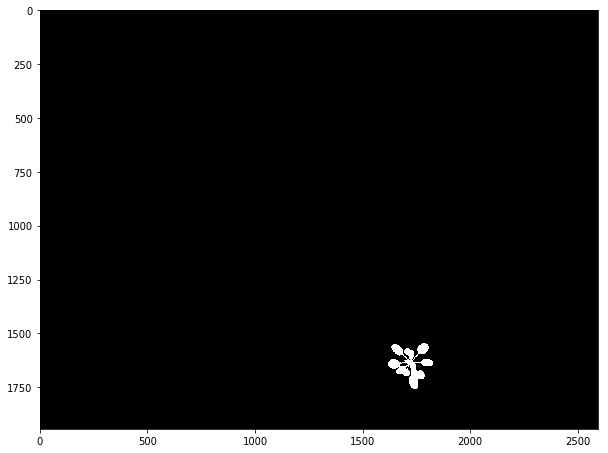

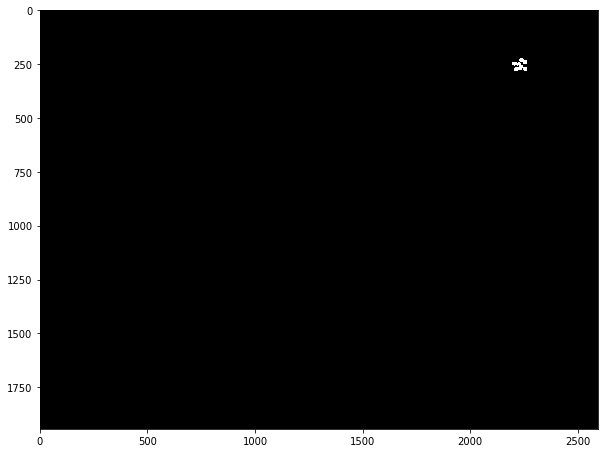

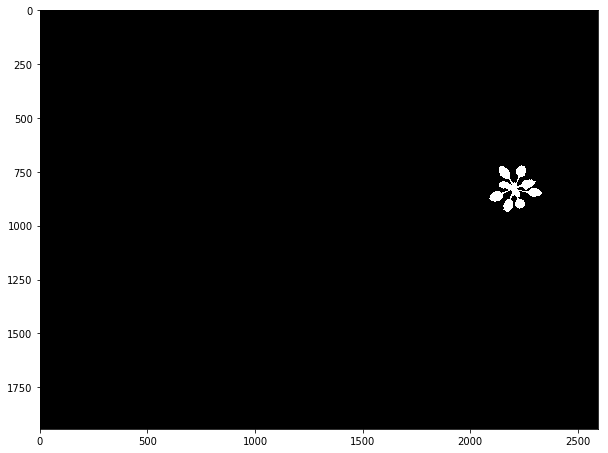

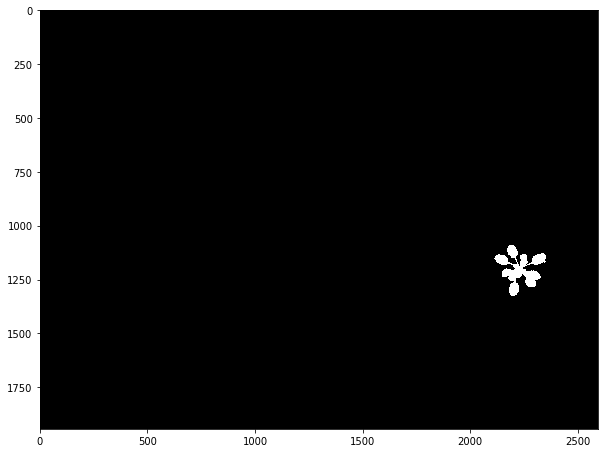

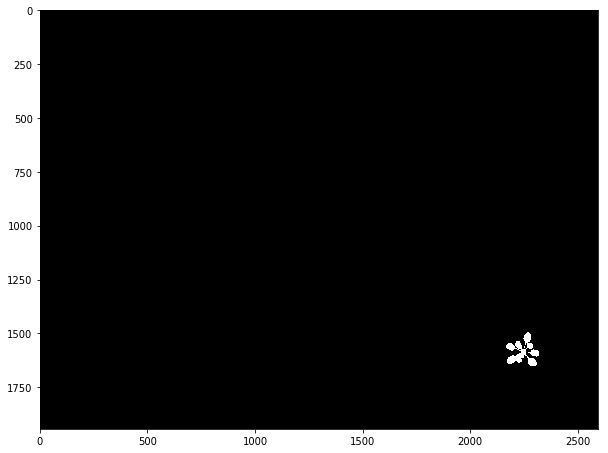

In [51]:
# Loop over clusters
# Each cluster is a list of contour indices
for cluster in clusters:
    # Skip if the cluster is empty
    if len(cluster) > 0:
        # Initialize an empty mask image
        mask = np.zeros(shape=np.shape(img)[:2], dtype=np.uint8)
        # Loop over each cluster index
        for i in cluster:
            # Draw contour i on the mask
            cv2.drawContours(mask, contours, i, (255), -1, hierarchy=hierarchy)
        # Plot each plant mask
        # Other analysis code could go here
        pcv.plot_image(mask)
    